# Guerlédan 2024/06: ctd

In [2]:
import os
from glob import glob

import pandas as pd
import numpy as np

#%matplotlib inline
import matplotlib.pyplot as plt

import hvplot.pandas # noqa

import pynsitu as pin
crs = pin.maps.crs
import seabot as sb
#crs = sb.crs

/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/utide/harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/utide/harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


## load data

In [3]:
# load yaml file
cp_yml = "guerledan_202310.yaml"
cp = pin.Campaign(cp_yml)

In [4]:
def load_swift(root_path, sub_path):
    
    files = sorted(glob(os.path.join(root_path, sub_path)))
    
    D = [load_swift_file(f) for f in files]
    
    D = [df for df in D if df.depth.max()>1]

    # summarize station data in a dataframe
    stations = pd.DataFrame(
        [
            dict(time=df.time.iloc[0], 
                 longitude=df.longitude.iloc[0], 
                 latitude=df.latitude.iloc[0],
                 temperature_max=df.temperature.max(),
                )
            for df in D
        ]
    )
    
    return D, stations

Columns_swift = [
    "date", 
    "depth", "pressure", 
    "sound_velocity", 
    "temperature", "salinity", "density", 
    "conductivity" , "nephelometer",
    "OBS", "turbidity"
]
Units_swift = [
    "", "m", "dBar", "Ms-1", "DegC", "PSU", "kg/m3", "mS/cm", "ntu", "btu", "ntu"
]
    
def load_swift_file(file):

    lon, lat = read_swift_asvp(file)
    
    with open(file) as f:
        lines = f.readlines()
        
    def parse_line(line):
        ls = line.replace("\n","").split(",")
        try:
            d = {**{"time": pd.Timestamp(ls[0])}, 
                 **{key: float(value) for key, value in zip(Columns_swift[1:], ls[1:])},
                }
        except:
            print(ls)
            print(line)
        return d

    i=2    
    df = pd.DataFrame([parse_line(line) for line in lines[i:]])
    #df = df.loc[df.salinity>0]
    #df["latitude"] = lat
    #df["longitude"] = lon
    
    df["longitude"] = lon
    df["latitude"] = lat

    df["z"] = -df["depth"]
    
    return df.set_index("z")

def read_swift_asvp(file, extension=".csv"):
    file = file.replace(extension, ".asvp")
    with open(file) as f:
        lines = f.readlines()
    line = lines[0]
    lon = float(line.split()[6])
    lat = float(line.split()[5])
    return lon, lat    

In [5]:
def load_aml(root_path, sub_path):
    
    files = sorted(glob(os.path.join(root_path, sub_path)))
    
    D = [load_aml_descent(f) for f in files]
    
    # summarize station data in a dataframe
    stations = pd.DataFrame(
        [
            dict(time=df.time.iloc[0], 
                 #longitude=df.longitude.iloc[0], 
                 #latitude=df.latitude.iloc[0],
                 temperature_max=df.temperature.max(),
                )
            for df in D
        ]
    )
    
    return D, stations        
    
def load_aml_descent(file, reader="txt"):

    if reader=="csv":
        df = read_aml_csv(file)
    elif reader=="txt":
        df = read_aml_txt(file)
        
    # select descent
    df = df.loc[
        (df["depth"] < df["depth"].max()-.5)
        & (df["depth"] > .5) 
        & (df.index < df["depth"].idxmax()) 
    ]

    # add descent speed
    dt = df.time.diff() / pd.Timedelta("1s")
    df["speed"] = df.depth.diff()/ dt
    
    df["z"] = -df["depth"]
    
    return df.set_index("z")

Columns_aml = [
    "date", "time", "battery", 
    "turbidity", "ADC", 
    "wipe", "ADC", 
    "pressure", "ADC", 
    "chloro-blue", "ADC", 
    "conductivity" ,"ADC", 
    "temperature", "ADC", 
    "salinity", "density", "calcSV", "depth",
]
Units_aml = [
    "yyyy-mm-dd", "hh:mm:ss.ss", "V", 
    "NTU", "2sComp", 
    "wipe", "wipe", 
    "dBar", "2sComp", 
    "ug/L", "2sComp", 
    "mS/cm", "none", 
    "C", "none", 
    "PSU", "kg/cm3", "m/s", "m",
]

def read_aml_csv(file):

    with open(file) as f:
        lines = f.readlines()

    i=1
    line = lines[0]
    while "[MeasurementData]" not in line:
        line = lines[i].replace("\n", "")
        if 'GPSLatitude' in line:
            lat = float(line.split("=")[1])
        if 'GPSLongitude' in line:
            lon = float(line.split("=")[1])
        i+=1
        
    def parse_line(line):
        ls = line.replace("\n","").split(",")
        try:
            d = {**{"time": pd.Timestamp(ls[0]+" "+ls[1])}, 
                 **{key: float(value) for key, value in zip(Columns_aml[2:], ls[2:])},
                }
        except:
            print(line)
        return d        
    
    df = pd.DataFrame([parse_line(line) for line in lines[i:]])
    df = df.loc[df.salinity>0]
    df["latitude"] = lat
    df["longitude"] = lon

    return df

def read_aml_txt(file):

    with open(file) as f:
        lines = f.readlines()
    
    # header
    columns = [c.lower() for c in lines[0].split()]
    
    def parse_line(line):
        ls = line.replace("\n","").split()
        try:
            d = {**{"time": pd.Timestamp(ls[0]+" "+ls[1])}, 
                 **{key: float(value) for key, value in zip(columns[2:], ls[2:])},
                }
        except:
            print(line)
        return d        
    
    df = pd.DataFrame([parse_line(line) for line in lines[2:]])
    #df = df.loc[df.salinity>0]
    #df["latitude"] = lat
    #df["longitude"] = lon

    return df

In [6]:
root_path = "/Users/aponte/Current_Projects/ensta/guerledan/202406/data_hydro/"

sw0, s0 = load_swift(root_path, "SWIFT_25062024am/*.csv")
sw1, s1 = load_swift(root_path, "SWIFT_25062024pm/*.csv")
sw2, s2 = load_swift(root_path, "SWIFT_26062024/VL*.csv")

am0, a0 = load_aml(root_path, "AML_25062024am/*.txt")
#am1, a1 = load_aml(root_path, "AML_25062024pm/*.txt")

# times do not match

# aml files correspond to morning files
# no lon/lat data for aml data

In [7]:
a0

,time,temperature_max
0,2024-06-25 07:00:35.310,22.832
1,2024-06-25 07:04:50.360,22.469
2,2024-06-25 07:09:58.660,22.554
3,2024-06-25 07:16:47.260,22.219
4,2024-06-25 07:27:24.010,23.662


In [8]:
s0

,time,longitude,latitude,temperature_max
0,2024-06-25 08:33:57,-3.020888,48.20985,21.681
1,2024-06-25 08:41:58,-3.014047,48.20652,21.475
2,2024-06-25 08:48:59,-3.015688,48.20163,21.292
3,2024-06-25 08:56:17,-3.018338,48.19753,20.971
4,2024-06-25 09:11:18,-3.038728,48.20362,20.875


In [95]:
s1

,time,longitude,latitude,temperature_max
0,2024-06-25 18:58:49,-3.020925,48.20944,22.885
1,2024-06-25 19:02:46,-3.014143,48.20624,22.490
2,2024-06-25 19:14:22,-3.017815,48.19762,22.218
3,2024-06-25 19:25:26,-3.039823,48.20348,23.678


In [93]:
s0.hvplot.points("longitude", "latitude", tiles=True, color="temperature_max", s=100, cmap="bmy").opts(width=600, height=400)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]   (temperature_max)

In [94]:
s1.hvplot.points("longitude", "latitude", tiles=True, color="temperature_max", s=100, cmap="bmy").opts(width=600, height=400)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]   (temperature_max)

In [11]:
def plot_variable(D, v, title=None, xlim=None, ylim=None):
    colors = pin.get_cmap_colors(len(D))

    fig, ax = plt.subplots(1,1)
    for df, c, i in zip(D, colors, range(len(D))):
        ax.plot(df[v], df.index, color=c, label=i)
    ax.grid()
    ax.legend()
    if ylim is not None:
        ax.set_ylim(*ylim)
    if title is not None:
        ax.set_title(title)

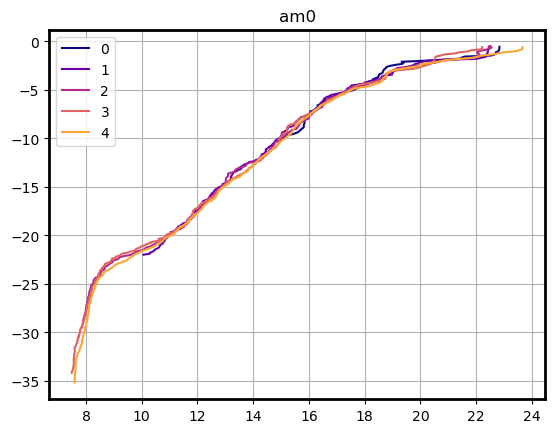

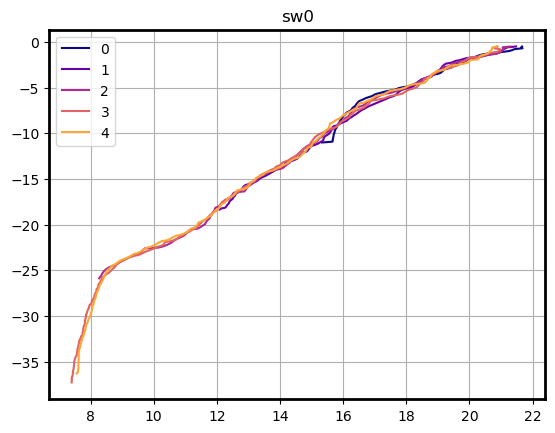

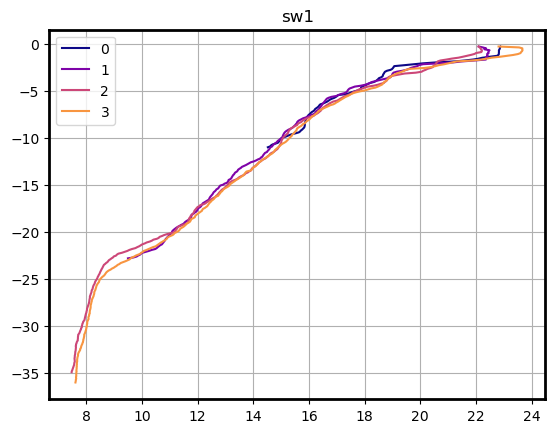

In [12]:
v = "temperature"
for D, label in zip([am0, sw0, sw1], ["am0", "sw0", "sw1"]):
    plot_variable(D, v, title=label, xlim=(7,24))

### combine with GPS

In [86]:
sw2[0]

,time,depth,pressure,sound_velocity,temperature,salinity,density,conductivity,nephelometer,OBS,turbidity,longitude,latitude
z,,,,,,,,,,,,,
-0.000,2024-06-26 14:08:07,0.000,0.000,0.0,28.160,0.0,0.0,0.0,0.012,9.879,0.012,-3.014365,48.19918
-0.000,2024-06-26 14:08:08,0.000,0.000,0.0,28.165,0.0,0.0,0.0,0.119,10.040,0.119,-3.014365,48.19918
0.002,2024-06-26 14:08:09,-0.002,-0.002,0.0,28.171,0.0,0.0,0.0,0.115,9.864,0.115,-3.014365,48.19918
0.001,2024-06-26 14:08:10,-0.001,-0.001,0.0,28.184,0.0,0.0,0.0,0.075,9.941,0.075,-3.014365,48.19918
0.002,2024-06-26 14:08:11,-0.002,-0.002,0.0,28.187,0.0,0.0,0.0,0.071,9.973,0.071,-3.014365,48.19918
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.001,2024-06-26 14:28:28,-0.001,-0.001,0.0,23.268,0.0,0.0,0.0,0.028,10.878,0.028,-3.014365,48.19918
-0.003,2024-06-26 14:28:29,0.003,0.003,0.0,23.265,0.0,0.0,0.0,0.111,10.918,0.111,-3.014365,48.19918
-0.003,2024-06-26 14:28:30,0.003,0.003,0.0,23.221,0.0,0.0,0.0,0.013,11.005,0.013,-3.014365,48.19918


In [15]:
# identifies start times

dt = "2s"

df = (
    sw2[0]
    .reset_index()
    .set_index("time")
    .drop(columns=["longitude", "latitude"])
)
df = df.resample(dt).mean()
df["depth"].hvplot()

:Curve   [time]   (depth)

In [16]:
def combine_gps(df, file, i_ref, t_ref, dev=False):

    dfg = pd.read_csv(file)

    def l2dm(f):
        # decode lon/lat
        s = np.sign(f)
        #deg = np.round(f/10**7)
        #_min = (f - deg*10**7)/10**5
        #return deg+_min/60
        return f/10**7

    dfg["latitude"] = dfg["GPS.Lat"].apply(l2dm)
    dfg["longitude"] = dfg["GPS.Lng"].apply(l2dm)

    if dev:
        return dfg
    
    dfg["time"] = (
        pd.to_timedelta(dfg["timestamp(ms)"]-dfg.loc[i_ref]["timestamp(ms)"], unit="ms") 
        + pd.Timestamp(t_ref)
    )

    dfg = dfg.set_index("time").resample("2s").mean()

    df = df.join(dfg, how="inner")
    
    return df

In [17]:
# load GPS
file = os.path.join(root_path, "SWIFT_26062024/CTD_1m.s-1.csv")
i_ref, t_ref = 647, "2024/06/26 14:20:12"
sw2_1m = combine_gps(df, file, i_ref, t_ref, dev=False)

file = os.path.join(root_path, "SWIFT_26062024/CTD_2m.s-1.csv")
i_ref, t_ref = 1320, "2024/06/26 14:13:18"
sw2_2m = combine_gps(df, file, i_ref, t_ref, dev=False)

In [21]:
dfg = sw2_1m
dfg["GPS.Spd"].hvplot()

:Curve   [time]   (GPS.Spd)

In [32]:
dfg.hvplot.points("longitude", "latitude", tiles="EsriImagery", color="w", alpha=.5).opts(width=600, height=400)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]

In [62]:
# determined with hvplot map above
lon_start, lat_start = -3.01462, 48.199265

def clip_range_az(legs, df):    
    D = {}
    for l in legs:
        _df = df.loc[l[1]:l[2]]
        _df["azimuth"], _, _df["r"] = \
            pin.geo.azimuth_distance(
            lon_start + _df.longitude*0, lat_start + _df.longitude*0, 
            _df.longitude, _df.latitude,
        )
        D[l[0]] = _df
        print(l)
    return D

In [69]:
legs1 = [
    ("1 m/s aller", "2024/06/26 14:20:21", "2024/06/26 14:22:24"),
    ("1 m/s retour", "2024/06/26 14:22:43", "2024/06/26 14:24:39"),
]

D1 = clip_range_az(legs1, sw2_1m)

legs2 = [
    ("2 m/s aller","2024/06/26 14:13:24", "2024/06/26 14:14:27"),
    ("2 m/s retour", "2024/06/26 14:14:43", "2024/06/26 14:15:48"),
]
D2 = clip_range_az(legs2, sw2_2m)

('1 m/s aller', '2024/06/26 14:20:21', '2024/06/26 14:22:24')
('1 m/s retour', '2024/06/26 14:22:43', '2024/06/26 14:24:39')
('2 m/s aller', '2024/06/26 14:13:24', '2024/06/26 14:14:27')
('2 m/s retour', '2024/06/26 14:14:43', '2024/06/26 14:15:48')


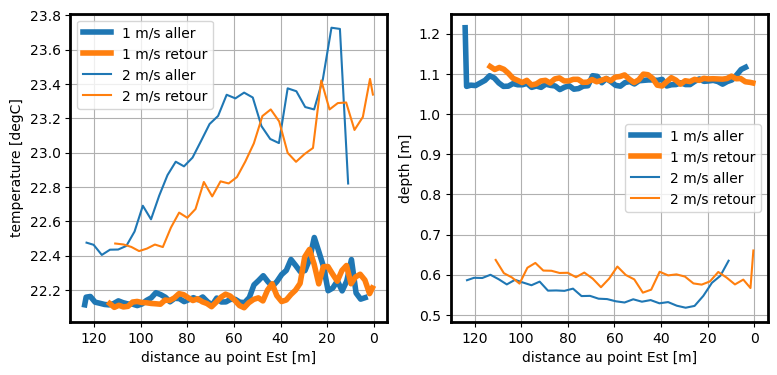

In [83]:
fig, axes = plt.subplots(1,2, figsize=(9,4))

ax = axes[0]

for (l, _df), c in zip(D1.items(), ["C0", "C1"]):
    ax.plot(_df.r, _df.temperature, color=c, lw=4, label=l)

for (l, _df), c in zip(D2.items(), ["C0", "C1"]):
    ax.plot(_df.r, _df.temperature, color=c, label=l)

ax.grid()
ax.set_xlabel("distance au point Est [m]")
ax.set_ylabel("temperature [degC]")
ax.legend()
ax.xaxis.set_inverted(True)


ax = axes[1]
for (l, _df), c in zip(D1.items(), ["C0", "C1"]):
    ax.plot(_df.r, _df.depth, color=c, lw=4, label=l)

for (l, _df), c in zip(D2.items(), ["C0", "C1"]):
    ax.plot(_df.r, _df.depth, color=c, label=l)

ax.grid()
ax.set_xlabel("distance au point Est [m]")
ax.set_ylabel("depth [m]")
ax.legend()
ax.xaxis.set_inverted(True)


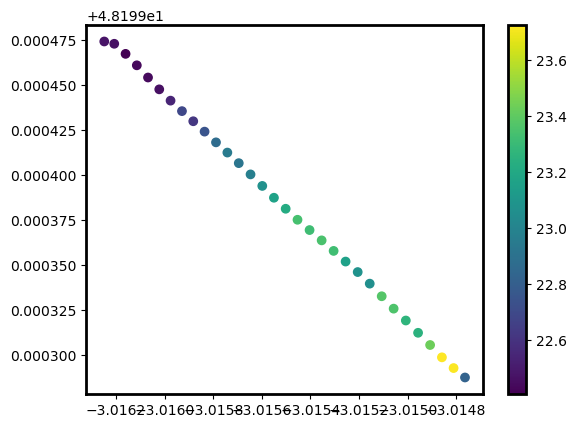

In [84]:
df = D2["2 m/s aller"]

fig, ax = plt.subplots(1,1)
h = ax.scatter(df.longitude, df.latitude, c=df.temperature)
fig.colorbar(h)

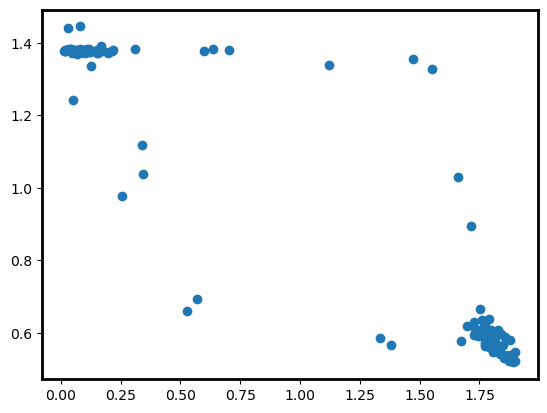

In [201]:
fig, ax = plt.subplots(1,1)
ax.scatter(df["GPS.Spd"], df["depth"])

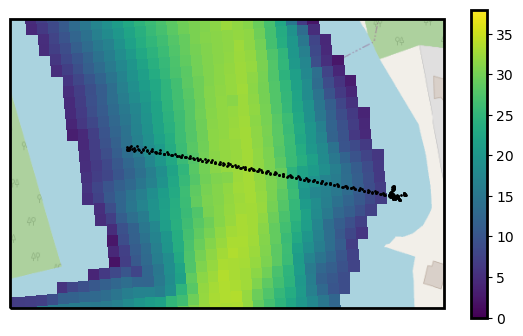

In [52]:
mapkw = dict(
    figsize=(7,4),
    extent=[-3.017, -3.0143, 48.1988, 48.2],
    #extent=cp["bounds"],
    #tile=False,
    #tile=True,
    tile_level=18,
    bathy=cp["bathy"]["path"], 
)


fig, ax = sb.plot_map(**mapkw)

df = sw2_1m
ax.scatter(df.longitude.values, df.latitude.values, c="k", s=1, transform=crs)
df = sw2_2m
ax.scatter(df.longitude.values, df.latitude.values, c="k", s=1, transform=crs)